<a href="https://colab.research.google.com/github/sairachawla/data-science-columbia/blob/main/assignment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
## Write up a report on U.N. World Happiness Data
### Saira Chawla

In [ ]:
#import sys
#!{sys.executable} -m pip install pyspark 

In [ ]:
## importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## importing from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# numeric = standardardscaler(), z score
# categorical = OneHotEncoder 
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
# pipeline steps for the transformer
from sklearn.impute import SimpleImputer
# how to handle missing values 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier

## importing from aimodelshare
from aimodelshare.aimsonnx import model_to_onnx
from onnxmltools.convert.sparkml.utils import FloatTensorType

## deep learning models: 
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


**Explore bivariate results**

In [ ]:
# editing the dataframe for the sake of bivariate visualization
df = pd.merge(X_train, y_train, left_index = True, right_index=True)
df['Average+'] = df['Average'] + df['High'] + df['Very High']
df.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks,Average,High,Low,Very High,Very Low,Average+
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000,1,0,0,0,0,1
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111,0,1,0,0,0,1
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000,1,0,0,0,0,1
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333,0,0,0,1,0,1
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111,0,1,0,0,0,1


Text(0.5, 1.0, 'GDP per capita by Happiness level')

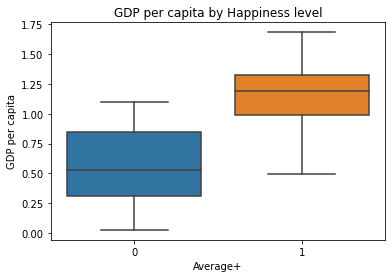

In [ ]:
sns.boxplot(x='Average+', y='GDP per capita', data=df)
plt.title("GDP per capita by Happiness level")

From the figure, we can see that GDP per capita increases as happiness increases or vice versa.

Text(0.5, 1.0, 'Terrorist Attacks by Happiness level')

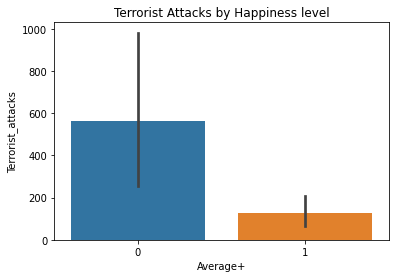

In [ ]:
sns.barplot(x='Average+', y='Terrorist_attacks', data=df)
plt.title("Terrorist Attacks by Happiness level")

From the figure, we can see that countries with below average happiness levels have more terrorist attacks.

Text(0.5, 1.0, 'Generosity by Happiness level')

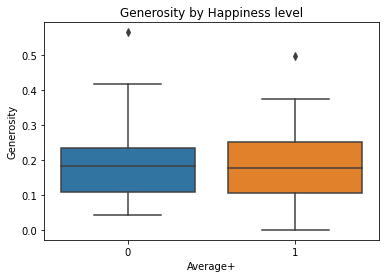

In [ ]:
sns.boxplot(x='Average+', y='Generosity', data=df)
plt.title("Generosity by Happiness level")

From the figure, we can see that across the various countries' happiness levels, genersoity tends to be the same, if not a little higher in countries with below average happiness.

### 2. Preprocess data and save proprocessor function

In [ ]:
# create preprocessing piplines for both numeric and categorical data
numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['region', 'sub-region']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# set up final preprocessor object with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# fit preprocessor object to X_train
preprocess = preprocessor.fit(X_train)

In [ ]:
# write a function to transform data with preprocessor
def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data = preprocess.transform(data)
    return preprocessed_data

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"")

Your preprocessor is now saved to 'preprocessor.zip'


### 3. Fit models on preprocessed data and save

#### Examine features that predict happiness categories using one or more models that allow for automatic feature selection

In [ ]:
auto_model = GradientBoostingClassifier()
auto_model.fit(preprocessor(X_train), y_train_labels)
auto_model.score(preprocessor(X_train), y_train_labels)

1.0

#### Experiment with different prediction models to try to predict World Happiness well (Fit and compare, at minimum, three models)

In [ ]:
# first model

param_grid = {'n_estimators': np.arange(10, 100, 10),'max_depth':[1, 3, 5]}
model1 = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)
model1.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(model1.best_score_))
print("best parameters: {}".format(model1.best_params_))

best mean cross-validation score: 0.704
best parameters: {'max_depth': 5, 'n_estimators': 90}


In [ ]:
# save model1 to local ONNX file

feature_count = preprocessor(X_test).shape[1]
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  

onnx_model1 = model_to_onnx(model1, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)
with open("model1.onnx", "wb") as f:
    f.write(onnx_model1.SerializeToString())

In [ ]:
# second model

param_grid = {'max_depth':[1, 3, 5]}
model2 = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=10)
model2.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(model2.best_score_))
print("best parameters: {}".format(model2.best_params_))

best mean cross-validation score: 0.626
best parameters: {'max_depth': 1}


In [ ]:
# save model2 to local ONNX file

feature_count = preprocessor(X_test).shape[1]
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  

onnx_model2 = model_to_onnx(model2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)
with open("model2.onnx", "wb") as f:
    f.write(onnx_model2.SerializeToString())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  


In [ ]:
# third model

param_grid = {'n_neighbors':np.arange(1,10)}
model3 = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=10)
model3.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(model3.best_score_))
print("best parameters: {}".format(model3.best_params_))

best mean cross-validation score: 0.626
best parameters: {'n_neighbors': 7}


In [ ]:
# save model3 to local ONNX file

feature_count = preprocessor(X_test).shape[1]
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  

onnx_model3 = model_to_onnx(model3, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)
with open("model3.onnx", "wb") as f:
    f.write(onnx_model3.SerializeToString())

### 4. Generate predictions, submit models to competition, and compare

In [ ]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [ ]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model1.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model1.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 597

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
#Submit Model 2: 

#-- Generate predicted values (Model 2)
prediction_labels = model2.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 598

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
#Submit Model 3: 

#-- Generate predicted values (Model 3)
prediction_labels = model3.predict(preprocessor(X_test))

# Submit Model 3 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model3.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 599

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)


In [ ]:
# Compare two or more models
data=mycompetition.compare_models([597, 598, 599], verbose=1)
mycompetition.stylize_compare(data)

,param_name,default_value,model_version_597
0,bootstrap,True,True
1,ccp_alpha,0.000000,0.000000
2,class_weight,None,None
3,criterion,gini,gini
4,max_depth,None,5
5,max_features,auto,auto
6,max_leaf_nodes,None,None
7,max_samples,None,None
8,min_impurity_decrease,0.000000,0.000000
9,min_samples_leaf,1,1


,param_name,default_value,model_version_598
0,ccp_alpha,0.000000,0.000000
1,criterion,friedman_mse,friedman_mse
2,init,None,None
3,learning_rate,0.100000,0.100000
4,loss,deviance,deviance
5,max_depth,3,1
6,max_features,None,None
7,max_leaf_nodes,None,None
8,min_impurity_decrease,0.000000,0.000000
9,min_samples_leaf,1,1


,param_name,default_value,model_version_599
0,algorithm,auto,auto
1,leaf_size,30,30
2,metric,minkowski,minkowski
3,metric_params,None,None
4,n_jobs,None,None
5,n_neighbors,5,7
6,p,2,2
7,weights,uniform,uniform


# 3 MORE MODELS

In [ ]:
feature_count=preprocessor(X_train).shape[1] #count features in input data

model4 = Sequential()
model4.add(Dense(128, input_dim=feature_count, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))

model4.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model4.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model4.fit(preprocessor(X_train), y_train, ## Note that keras models require a one-hot-encoded y_train object
               batch_size = 20, 
               epochs = 300, validation_split=0.25)

Epoch 1/300
4/4 [==============================] - 1s 61ms/step - loss: 1.6186 - accuracy: 0.2273 - val_loss: 1.5871 - val_accuracy: 0.3636
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5965 - accuracy: 0.2121 - val_loss: 1.5704 - val_accuracy: 0.3636
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5764 - accuracy: 0.2424 - val_loss: 1.5552 - val_accuracy: 0.4091
Epoch 4/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5565 - accuracy: 0.3636 - val_loss: 1.5424 - val_accuracy: 0.4091
Epoch 5/300
4/4 [==============================] - 0s 8ms/step - loss: 1.5410 - accuracy: 0.4091 - val_loss: 1.5306 - val_accuracy: 0.4091
Epoch 6/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5258 - accuracy: 0.4242 - val_loss: 1.5159 - val_accuracy: 0.4545
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5076 - accuracy: 0.4697 - val_loss: 1.5051 - val_accuracy: 0.4545
Epoch 8/300
4/4 [======

In [ ]:
# save model 4 to ONNX file

onnx_model4 = model_to_onnx(model4, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model4.SerializeToString())

In [ ]:
# fifth model

param_grid = {'n_estimators':[10, 100, 10], 'learning_rate':[1.0], 'max_depth':[1, 3, 5]}
model5 = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=10)
model5.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(model5.best_score_))
print("best parameters: {}".format(model5.best_params_))

best mean cross-validation score: 0.625
best parameters: {'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
# save model5 to local ONNX file

feature_count = preprocessor(X_test).shape[1]
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  

onnx_model5 = model_to_onnx(model5, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)
with open("model5.onnx", "wb") as f:
    f.write(onnx_model5.SerializeToString())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  


In [ ]:
# sixth model

param_grid = {'n_estimators':[10, 100, 10], 'verbose':[1.0], 'max_features':[1, 3, 5]}
model6 = GridSearchCV(BaggingClassifier(), param_grid=param_grid, cv=10)
model6.fit(preprocessor(X_train), y_train_labels)
print("best mean cross-validation score: {:.3f}".format(model6.best_score_))
print("best parameters: {}".format(model6.best_params_))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

best mean cross-validation score: 0.646
best parameters: {'max_features': 5, 'n_estimators': 100, 'verbose': 1.0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [ ]:
# save model6 to local ONNX file

feature_count = preprocessor(X_test).shape[1]
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  

onnx_model6 = model_to_onnx(model6, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)
with open("model6.onnx", "wb") as f:
    f.write(onnx_model6.SerializeToString())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  


In [ ]:
# Submit Model 4

#-- Generate predicted y values
#Note: Keras predict returns the predicted column index location for classification models
prediction_column_index=model4.predict(preprocessor(X_test)).argmax(axis=1)

# extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 4 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

3/3 [==============================] - 0s 5ms/step
Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 614

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
#Submit Model 5: 

#-- Generate predicted values (Model 5)
prediction_labels = model5.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model5.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 611

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
#Submit Model 6: 

#-- Generate predicted values (Model 6)
prediction_labels = model6.predict(preprocessor(X_test))

# Submit Model 6 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model6.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 612

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)